# 1. Representing Data

## Data as Vectors
* TODO Definitions
* Dataset with N samples and M features:

\begin{pmatrix}
    x_{11} & x_{12} & \dots \\
    \vdots & \ddots & \\
    x_{n1} &        & x_{nm} 
\end{pmatrix}

In [27]:
import pandas as pd
import sklearn.datasets
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

plt.style.use('seaborn-darkgrid')

In [50]:
wine = sklearn.datasets.load_wine()
df = pd.DataFrame(wine['data'], columns=wine['feature_names'])
df.loc[:, 'type'] = wine['target']
df.head()

,alcohol,malic_acid,ash,alcalinity_of_ash,magnesium,total_phenols,flavanoids,nonflavanoid_phenols,proanthocyanins,color_intensity,hue,od280/od315_of_diluted_wines,proline,type
0,14.23,1.71,2.43,15.6,127.0,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065.0,0
1,13.20,1.78,2.14,11.2,100.0,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050.0,0
2,13.16,2.36,2.67,18.6,101.0,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185.0,0
3,14.37,1.95,2.50,16.8,113.0,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480.0,0
4,13.24,2.59,2.87,21.0,118.0,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735.0,0


In [53]:
df[['proline', 'magnesium', 'type']].head()

,proline,magnesium,type
0,1065.0,127.0,0
1,1050.0,100.0,0
2,1185.0,101.0,0
3,1480.0,113.0,0
4,735.0,118.0,0


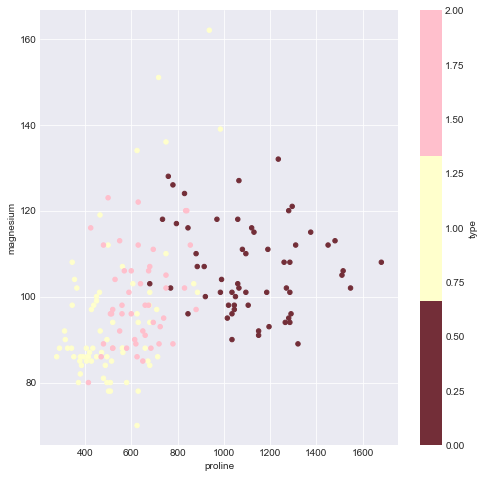

In [52]:
fig, ax = plt.subplots(figsize=(8, 8))

df.plot.scatter(
    x='proline',
    y='magnesium',
    c='type',
    cmap=ListedColormap([(0.45, 0.18, 0.22), (1, 1, 0.8), (1, 0.75, 0.8)]),
    ax=ax
);

## Feature Extraction
* Deriving informative and non-redundant values out of raw data to facilitate the learning
* Examples (images, sound, ...)
* Dimensionality reduction
* Feature learning

## Example: Feature Extraction For Sound Data

* Read sound data
* plots in time and frequency domain
* extract two simple features in frequency domain OR multiple features, apply PCA to get 2?
* show data matrix
* scatterplot